In [1]:
from __future__ import absolute_import, division, print_function

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow import keras
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

import skimage
from skimage import data
from skimage.transform import resize
# import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
# %matplotlib inline
import glob


tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
#data = input_data.read_data_sets('data/fashion')

In [3]:
directory = '/Users/russ/gitlab/equivariant-neural-network-2/files/codes/data/mnist_png/'

In [4]:
def str_to_vect(string, length):
    string = int(string)
    res = []
    for i in range(length):
        if i != string:
            res.append(0)
        else:
            res.append(1)
    return res

In [5]:
def str_to_vect2(label, angle):
    label = int(label)
    angle = int(angle)
    position = (4 - angle)%4
    vector = []
    for i in range(4):
        for j in range(10):
            if i == position and j == label:
                vector.append(1)
            else:
                vector.append(0)
    return vector

In [6]:
#loaddata
def loaddata(s):
    filelist = glob.glob(directory + s + '/*.png')
    y_temp = []
    x_temp = []
    print (directory + s + '/*.png')
    for fname in filelist:
        short_name = fname.split('/')[-1]
        label, angle, name = short_name.split('_')
        img = mpimg.imread(fname)
        x_temp.append(img)
        vector = str_to_vect2(label, angle)
        y_temp.append(vector)

    x = np.asarray(x_temp)
    y = np.asarray(y_temp)
    print (s + ' import done. the shapes of x and y are:', x.shape, y.shape)
    return x, y


In [7]:
train_x, train_y = loaddata('training')

/Users/russ/gitlab/equivariant-neural-network-2/files/codes/data/mnist_png/training/*.png
training import done. the shapes of x and y are: (60000, 28, 28) (60000, 40)


In [8]:
test_x, test_y = loaddata('testing')

/Users/russ/gitlab/equivariant-neural-network-2/files/codes/data/mnist_png/testing/*.png
testing import done. the shapes of x and y are: (10000, 28, 28) (10000, 40)


In [9]:
# fashion_mnist = keras.datasets.fashion_mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [10]:
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
# train_images.shape

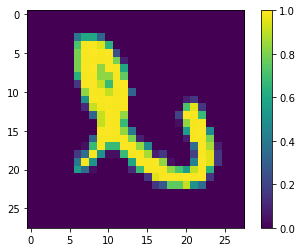

In [12]:
plt.figure()
plt.imshow(test_x[5])
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
test_y[5]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[train_labels[i]])
# plt.show()

In [15]:
train_x.shape

(60000, 28, 28)

In [16]:
def compute_cost(Z, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))    
    return cost

In [42]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
    g1_input_layer = tf.image.rot90(input_layer)
    g2_input_layer = tf.image.rot90(input_layer, k=2)
    g3_input_layer = tf.image.rot90(input_layer, k=3)
    # Convolutional Layer #1
    conv1_0 = tf.layers.conv2d(
      inputs=input_layer,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      reuse = None,
      name = 'conv1')
    
    conv1_1 = tf.layers.conv2d(
      inputs=g1_input_layer,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      reuse = True,
      name = 'conv1')    

    conv1_2 = tf.layers.conv2d(
      inputs=g2_input_layer,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      reuse = True,
      name = 'conv1')  

    conv1_3 = tf.layers.conv2d(
      inputs=g3_input_layer,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      reuse = True,
      name = 'conv1') 
    
    conv1    = tf.concat([conv1_0, conv1_1, conv1_2, conv1_3], axis = 3)
    g1_conv1 = tf.concat([conv1_1, conv1_2, conv1_3, conv1_0], axis = 3)
    g2_conv1 = tf.concat([conv1_2, conv1_3, conv1_0, conv1_1], axis = 3)
    g3_conv1 = tf.concat([conv1_3, conv1_0, conv1_1, conv1_2], axis = 3)
    
    # Pooling Layer #1
    #pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=3)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2_0 = tf.layers.conv2d(
      inputs=conv1,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      reuse = None,
      activation=tf.nn.relu,
      name = 'conv2')
    
    conv2_1 = tf.layers.conv2d(
      inputs=g1_conv1,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      reuse = True,
      activation=tf.nn.relu,
      name = 'conv2')

    conv2_2 = tf.layers.conv2d(
      inputs=g2_conv1,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      reuse = True,
      activation=tf.nn.relu,
      name = 'conv2')

    conv2_3 = tf.layers.conv2d(
      inputs=g3_conv1,
      filters=80,
      kernel_size=[3, 3],
      padding="same",
      reuse = True,
      activation=tf.nn.relu,
      name = 'conv2')
    
    conv2    = tf.concat([conv2_0, conv2_1, conv2_2, conv2_3], axis = 3)
    g1_conv2 = tf.concat([conv2_1, conv2_2, conv2_3, conv2_0], axis = 3)
    g2_conv2 = tf.concat([conv2_2, conv2_3, conv2_0, conv2_1], axis = 3)
    g3_conv2 = tf.concat([conv2_3, conv2_0, conv2_1, conv2_2], axis = 3)
    #pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[3, 3], strides=3)

    conv3_0 = tf.layers.conv2d(
      inputs=conv2,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      reuse = None,
      activation=tf.nn.relu,
      name = 'conv3')

    conv3_1 = tf.layers.conv2d(
      inputs=g1_conv2,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      reuse = True,
      activation=tf.nn.relu,
      name = 'conv3')

    conv3_2 = tf.layers.conv2d(
      inputs=g2_conv2,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      reuse = True,
      activation=tf.nn.relu,
      name = 'conv3')

    conv3_3 = tf.layers.conv2d(
      inputs=g3_conv2,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      reuse = True,
      activation=tf.nn.relu,
      name = 'conv3')
    
    conv3    = tf.concat([conv3_0, conv3_1, conv3_2, conv3_3], axis = 3)
    g1_conv3 = tf.concat([conv3_1, conv3_2, conv3_3, conv3_0], axis = 3)
    g2_conv3 = tf.concat([conv3_2, conv3_3, conv3_0, conv3_1], axis = 3)
    g3_conv3 = tf.concat([conv3_3, conv3_0, conv3_1, conv3_2], axis = 3)
    
    pool4_0 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[4, 4], strides=4)
    pool4_1 = tf.layers.max_pooling2d(inputs=g1_conv3, pool_size=[4, 4], strides=4)
    pool4_2 = tf.layers.max_pooling2d(inputs=g2_conv3, pool_size=[4, 4], strides=4)
    pool4_3 = tf.layers.max_pooling2d(inputs=g3_conv3, pool_size=[4, 4], strides=4)
    
    pool4_0_flat = tf.reshape(pool4_0, [-1, 7 * 7 * 128])
    pool4_1_flat = tf.reshape(pool4_1, [-1, 7 * 7 * 128])
    pool4_2_flat = tf.reshape(pool4_2, [-1, 7 * 7 * 128])
    pool4_3_flat = tf.reshape(pool4_3, [-1, 7 * 7 * 128])
    
    #print('pool4_0_flat=', pool4_0_flat.shape)
    
    dense_0 = tf.layers.dense(inputs=pool4_0_flat, 
                              units=1024, 
                              activation=tf.nn.relu,
                              reuse = None,
                              name = 'dense')

    dense_1 = tf.layers.dense(inputs=pool4_1_flat, 
                              units=1024, 
                              activation=tf.nn.relu,
                              reuse = True,
                              name = 'dense')

    dense_2 = tf.layers.dense(inputs=pool4_2_flat, 
                              units=1024, 
                              activation=tf.nn.relu,
                              reuse = True,
                              name = 'dense')
    
    dense_3 = tf.layers.dense(inputs=pool4_3_flat, 
                              units=1024, 
                              activation=tf.nn.relu,
                              reuse = True,
                              name = 'dense')
    
    #print('dense_0=', dense_0.shape)
    #dropout = tf.layers.dropout(
      #inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits_0 = tf.layers.dense(inputs=dense_0,
                               units=10,
                               reuse = None,
                               name = 'logi'
                              )
    #print ('logits_0_reshape', logits_0_reshape.shape)

    logits_1 = tf.layers.dense(inputs=dense_1, 
                               units=10,
                               reuse = True,
                               name = 'logi'
                              )

    
    logits_2 = tf.layers.dense(inputs=dense_2, 
                               units=10,
                               reuse = True,
                               name = 'logi'
                              )
    
    logits_3 = tf.layers.dense(inputs=dense_3, 
                               units=10,
                               reuse = True,
                               name = 'logi'
                              )
    
    #print ('logits_0.shape =', logits_0.shape)
    #print([x.name for x in tf.global_variables()])
    final = tf.concat([logits_0, logits_1, logits_2, logits_3], axis = 1)
    #print ('final_flat.shape =', final_flat.shape)
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=final, axis= 1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(final, name="softmax_tensor")
    }
    
    #print ('prediction looks fine')
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    #print (final.shape, labels.shape)
    loss = compute_cost(final, labels)
    #loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=final_flat)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=tf.argmax(input=labels, axis= -1), predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [43]:
#Load minist training and eval data
#instead, this loads the mnist
# ((train_data, train_labels),
# (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()
# train_data = train_data / 255.0
# eval_data = eval_data / 255.0
# train_labels = train_labels.astype(np.int32)
# eval_labels = eval_labels.astype(np.int32)

In [44]:
# #either use this cell, or the cell above
# train_data = train_x / 255.0
# eval_data = test_x / 255.0

# train_labels = np.argmax(train_y, axis = -1).astype(np.int32)  # not required
# eval_labels = np.argmax(test_y, axis = -1).astype(np.int32)  # not required

In [45]:
train_data = train_x / 255.0
eval_data = test_x / 255.0

train_labels = train_y.astype(np.int32)  # not required
eval_labels = test_y.astype(np.int32)  # not required

In [46]:
train_data.shape, train_labels.shape

((60000, 28, 28), (60000, 40))

In [47]:
eval_data.shape, eval_labels.shape

((10000, 28, 28), (10000, 40))

In [48]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13144ce10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [49]:
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [50]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=200,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:probabilities = [[0.02501056 0.02500975 0.02499076 ... 0.02501195 0.02499745 0.0249816 ]
 [0.02500858 0.02500818 0.02499193 ... 0.02500384 0.02499986 0.02498108]
 [0.02501018 0.02500887 0.02499267 ... 0.02500757 0.02499852 0.02498125]
 ...
 [0.02500793 0.02500525 0.02499345 ... 0.0250061  0.02500187 0.02498598]
 [0.02501057 0.0250127  0.02498638 ... 0.02500574 0.02499798 0.02497704]
 [0.02500679 0.02500747 0.02499319 ... 0.0250047  0.02499846 0.02498267]]
INFO:tensorflow:loss = 3.6889029, step = 1
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:t

In [59]:
mnist_classifier.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt-201
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 201 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:loss = 1.0294033, step = 202
INFO:tensorflow:Saving checkpoints for 231 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 262 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 294 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:global_step/sec: 0.0507565
INFO:tensorflow:loss = 0.58555543, step = 302 (1970.201 sec)
INFO:tensorf

INFO:tensorflow:loss = 0.12332801, step = 1802 (1887.376 sec)
INFO:tensorflow:Saving checkpoints for 1830 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1862 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1894 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:global_step/sec: 0.0527354
INFO:tensorflow:loss = 0.11119108, step = 1902 (1896.274 sec)
INFO:tensorflow:Saving checkpoints for 1926 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1958 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1990 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt.
INFO:tensorflow:global_step/sec: 0.0527407
INFO:tensorflow:loss = 0.16992563, step = 2002 (1896.065 s

In [60]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-04T03:02:02Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt-2201
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-04-03:09:26
INFO:tensorflow:Saving dict for global step 2201: accuracy = 0.9577, global_step = 2201, loss = 0.14063439
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2201: /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt-2201
{'accuracy': 0.9577, 'loss': 0.14063439, 'global_step': 2201}


In [95]:
samples_x, samples_y = loaddata('samples')
samples_x = samples_x/np.float32(255)

/Users/russ/gitlab/equivariant-neural-network-2/files/codes/data/mnist_png/samples/*.png
samples import done. the shapes of x and y are: (4, 28, 28) (4, 40)


In [96]:
samples_x.shape

(4, 28, 28)

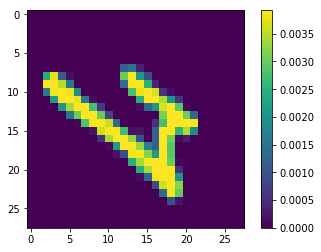

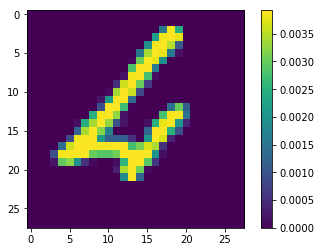

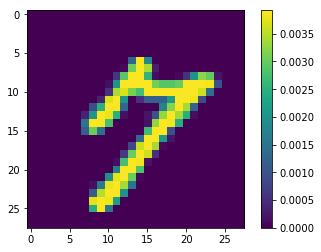

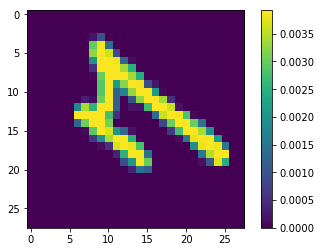

In [97]:
plt.figure()
plt.imshow(samples_x[0])
plt.colorbar()
plt.grid(False)

plt.figure()
plt.imshow(samples_x[1])
plt.colorbar()
plt.grid(False)

plt.figure()
plt.imshow(samples_x[2])
plt.colorbar()
plt.grid(False)

plt.figure()
plt.imshow(samples_x[3])
plt.colorbar()
plt.grid(False)

#plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)
plt.show()

In [98]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": samples_x},
    shuffle=False)

In [110]:
predictions = mnist_classifier.predict(input_fn = pred_input_fn)

In [111]:
def decode(c):
    return c%10, (4 -(c-c%10)/10)%4 * 90

In [112]:
for prediction in predictions:
    print (decode(prediction['classes']), '\n', prediction['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpwgbhb4nm/model.ckpt-2201
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(7, 270.0) 
 [2.05644876e-11 6.89517124e-11 5.01109980e-07 6.22865715e-09
 5.35240304e-07 8.97988194e-12 8.34397795e-09 1.27654602e-07
 1.18565313e-09 3.18130478e-09 3.08501069e-04 1.61850835e-08
 4.97675671e-07 2.57115262e-05 1.05485029e-03 3.34337237e-04
 4.84817519e-08 8.35981488e-01 1.82691263e-04 1.62110627e-01
 4.72504891e-12 7.35331907e-16 1.25806601e-10 3.94726135e-13
 1.83841592e-12 1.07023745e-13 1.10608278e-12 3.46214758e-11
 1.79656135e-13 1.57663108e-12 5.79642349e-15 1.74851886e-17
 1.78956502e-12 4.06364692e-16 8.03018893e-13 1.37484061e-14
 4.26493346e-12 4.94882846e-18 3.94265207e-15 1.48675974e-16]
(7, 180.0) 
 [5.79642349e-15 1.74851886e-17 1.78956502e-12 4.063

In [89]:
c = 17
print (c, c%10, (4 -(c-c%10)/10)%4 * 90, 'degree')

17 7 270.0 degree


In [ ]:
8.35981488